# Image cleaning

**Author(s):**
 - Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

**Description:**

This notebook contains DL1-image-cleaning plots and benchmark proposals for the _protopipe_ pipeline.  
This was mainly triggered by the step-by-step comparison against _CTA-MARS_, but it can be extended to other pipelines as well.  
**NOTE** Let's try to follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding those benchmarks or proposing new ones.  
**WARNING** Contrary to the calibration notebook, I am still working on this one, so it's a bit messy and incomplete! 

**Requirements:**

To run this notebook you will need a DL1 file which can be generated using _protopipe.scripts.write_dl1.py_ .    
Reference simtel-file, plots, values and settings can be found [here (please, always refer to the latest version)](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Comparisons_between_pipelines) until we have a more automatic and fancy approach (aka [cta-benchmarks](https://github.com/cta-observatory/cta-benchmarks)+[ctaplot](https://github.com/cta-observatory/ctaplot)).  

The data format required to run the notebook is the current one used by _protopipe_ . Later on it will be the same as in _ctapipe_ .  
**WARNING:** Mono-telescope images (2 triggers - 1 image or 1 trigger - 1 image) are not currently taken into account by the publicly available development version (the new DL1 script will have them), until then expect a somewhat lower statistics.

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.

**TODO:**  
* add missing plots in section [Total image charge ("Intensity") resolution for selected images"](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#Total-image-charge-Intensity-resolution-for-selected-images)
* check for other relevant benchmarks

## Imports

In [38]:
# import tables
# import h5py
from pathlib import Path
import numpy as np
import pandas
from scipy.stats import binned_statistic, binned_statistic_2d, cumfreq, percentileofscore
from astropy import units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

from ctapipe.instrument import OpticsDescription
from ctapipe.image.hillas import camera_to_shower_coordinates

## Functions

### Load the base data file or reset it if overwritten

In [41]:
def load_reset_dl1_pandas(indir = "./", fileName = "dl1_tail_gamma_z20_az180_LaPalma_baseline_run100_withMono.h5", config="test"):
    """(Re)load the file containing DL1(a) data and extract the data per telescope type."""
    # load DL1 images
    data_LST = pandas.read_hdf(f"{indir}/{fileName}", "/feature_events_LSTCam")
    data_MST = pandas.read_hdf(f"{indir}/{fileName}", "/feature_events_NectarCam")
    suffix = config # all generated plots will have this as a suffix in their name
    return data_LST, data_MST, suffix

### DL1 quantities to plot

In [88]:
def dl1_quantities(data):
    """A dictionary of the quantities available with this format of DL1 in protopipe.
    
    WARNING: for the moment protopipe uses one cleaning algorithm (biggest cluster),
    even though it allows for two;
    this means that all the quantities with the suffix "_reco" are the same as those without suffix.
    """
    
    dictionary = {

            "Intensity [#phe]"   : data["sum_signal_cam"], # aka SIZE
            "Width [m]"          : data["width"],
            "Length [m]"         : data["length"],
            "Skewness"           : data["skewness"],
            "Kurtosis"           : data["kurtosis"],
            "H_max [m]"          : data["h_max"],
            "n_pixel"            : data["n_pixel"],
            "Ellipticity"        : data["ellipticity"],
            "Leakage 1"          : data["leakage_pixels_width_1"],  # see cta-observatory/protopipe#41
            "psi"                : data["psi_reco"],
            "cog_x"              : data["cog_x"],
            "cog_y"              : data["cog_y"],
            "cog_r"              : data["local_distance_reco"],
        }
    
    return dictionary

### Add statistical information to a plot

In [89]:
def add_stats(x, ax, x_coord, y_coord):
    """Add a textbox containing statistical information."""
    mu = x.mean()
    median = np.median(x)
    sigma = x.std()
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(x_coord, y_coord, 
            textstr, 
            transform=ax.transAxes, 
            fontsize=10,
            horizontalalignment='left',
            verticalalignment='center', 
            bbox=props)

## Plots

First we check if a _plots_ folder exists already.  
If not, we create it.

In [90]:
Path("./plots_image_cleaning").mkdir(parents=True, exist_ok=True)

In [91]:
# fill with the correct path, filename of the generated file in your system
data_LST, data_MST, config = load_reset_dl1_pandas(indir = "/Users/michele/Applications/ctasoft/dirac/data/analyses/protopipe_021dev_ctapipe070/data/TRAINING/for_energy_estimation",
                                                   fileName = "dl1_tail_gamma_merged.h5",
                                                   config="test")
cameras = ["LSTCam", "NectarCam"]

In [92]:
# Get DL1 quantities as numpy arrays or pandas.Dataframe columns
DL1_LST = dl1_quantities(data_LST)
DL1_MST = dl1_quantities(data_MST)
DL1 = [DL1_LST, DL1_MST]

In [93]:
# Transform DL1 dictionaris in pandas DataFrames
for camera_index in range(len(cameras)):
    DL1[camera_index] = pandas.DataFrame.from_dict(DL1[camera_index])

### Image-parameter distributions

From [here](https://www.overleaf.com/16933164ghbhvjtchknf) : use all telescope events with; this is not a benchmark, but useful for monitoring (best done in energy bins)

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


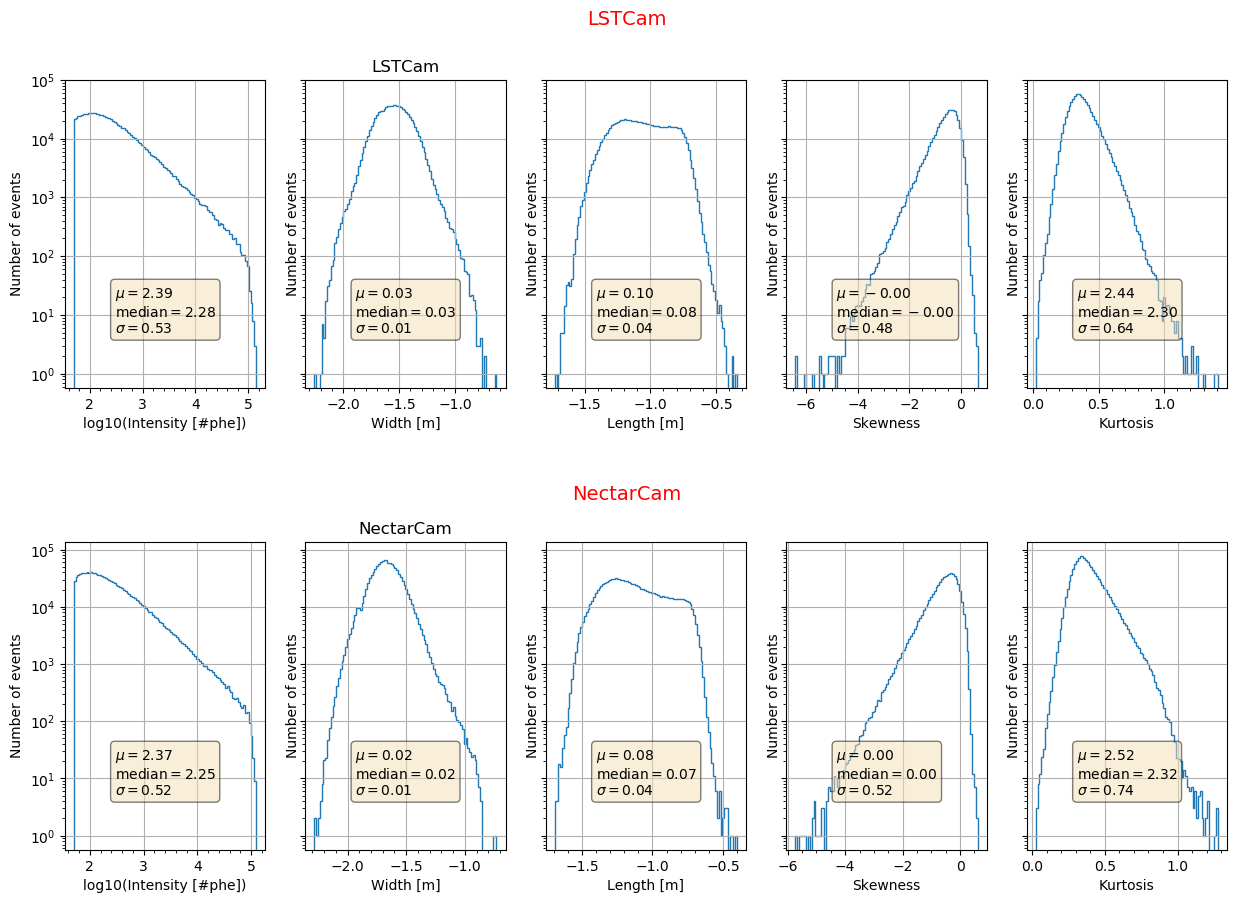

In [102]:
nbins = 100
parameters = ["Intensity [#phe]", "Width [m]", "Length [m]", "Skewness", "Kurtosis"]

fig, axes = plt.subplots(ncols=len(parameters), 
                         nrows=len(cameras), 
                         figsize=(15, 10), 
                         tight_layout=False,
                         sharey="row")

plt.subplots_adjust(hspace = 0.5 )

for camera_index in range(len(cameras)):
    
    plt.figtext(0.5,0.95 - camera_index*0.95/len(cameras), cameras[camera_index], ha="center", va="top", fontsize=14, color="r")
    
    for i,key in enumerate(parameters):
        
        axes[camera_index, 1].set_title(cameras[camera_index])
        
        axes[camera_index, i].set_ylabel("Number of events")
        axes[camera_index, i].set_yscale('log')

        if key == "Intensity [#phe]":
            axes[camera_index, i].set_xlabel(f"log10({key})")
            add_stats(np.log10(DL1[camera_index][parameters[i]]), axes[camera_index, i], 0.25, 0.25)
        else:
            axes[camera_index, i].set_xlabel(f"{key}")
            add_stats(DL1[camera_index][parameters[i]], axes[camera_index, i], 0.25, 0.25)

        axes[camera_index, i].hist(np.log10(DL1[camera_index][parameters[i]]), bins=nbins, histtype="step")

        axes[camera_index, i].minorticks_on()
        axes[camera_index, i].grid()

plt.show()
fig.savefig(f"./plots_image_cleaning/{key.split(' ')[0]}_{cameras[camera_index]}_protopipe_{config}.png")